## Generative Adversarial Network (GAN)

GAN is basically an approach to generative modeling that generates a new set of data based on training data that look like training data.

Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.


### **ARCHITECTURE :**

The GAN model architecture involves two sub-models :<br>
- **Generator** Model that is used to generate new plausible examples from the problem domain.
- **Discriminator** Model that is used to classify examples as real (from the domain) or fake (generated)<br>

A generative model G captures the data distribution, and a discriminative model D that estimates the probability that a sample came from the training data rather than G.


### GAN as a Zero-Sum Game

The training procedure for G is to maximize the probability of D making a mistake .<br>
In this case, zero-sum means that when the discriminator successfully identifies real and fake samples, it is rewarded or no change is needed to the model parameters, whereas the generator is penalized with large updates to model parameters.<br>
whereas when the generator fools the discriminator, it is rewarded, or no change is needed to the model parameters, but the discriminator is penalized and its model parameters are updated.


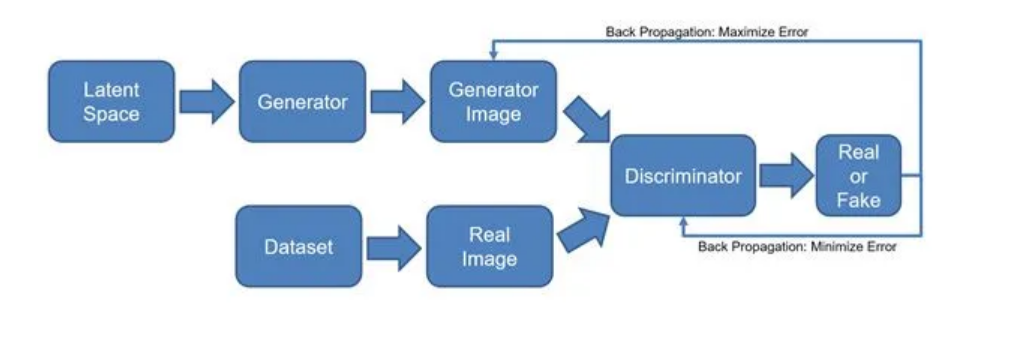

## **Applications** :
- Generate Examples for Image Datasets
- Image-to-Image Translation
- Text-to-Image Translation
- Generate Photographs of Human Faces
- Generate New Human Poses

#### GAN Impletation on CIFAR-10 Dataset

In [2]:
## loading dataset and keras libraries
import numpy as np
from tensorflow import keras
from keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt
from keras.models import Sequential , load_model
from keras.layers import Conv2D, Conv2DTranspose, Flatten, Dropout, LeakyReLU, Reshape , Dense
from keras.utils.vis_utils import plot_model

Shape of x_train: (50000, 32, 32, 3) shape of y_train (50000, 1)


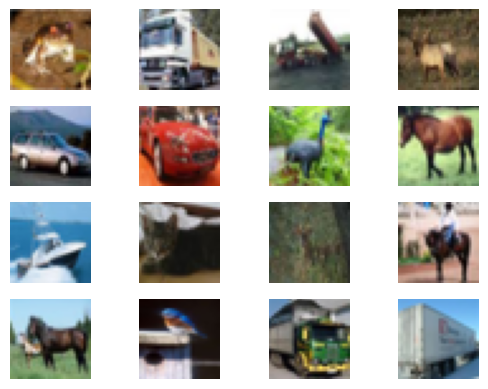

In [38]:
## load image into memory:
(x_train, y_train), (x_test, y_test)= load_data()
print(f"Shape of x_train: {x_train.shape} shape of y_train {y_train.shape}")

## visualizing the data
for i in range(16):
  plt.subplot(4,4,1+i)
  plt.axis('off')
  plt.imshow(x_train[i])
plt.show()


In [61]:
## define the discriminator model:
def discriminator(in_shape=(32,32,3)):
  model=Sequential()
  model.add(Conv2D(64, kernel_size=(3,3), padding='same',input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128, kernel_size=(3,3), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  model.add(Conv2D(128, kernel_size=(3,3), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  model.add(Conv2D(256, kernel_size=(3,3), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))

  opt= keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])

  return model

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_26 (Conv2D)          (None, 4, 4, 256)       

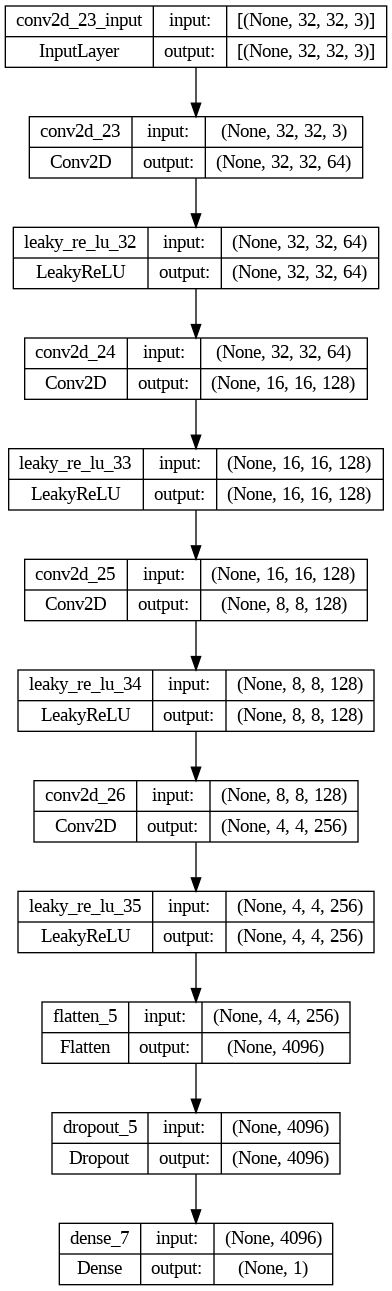

In [40]:
model=discriminator()
model.summary()
plot_model(model, to_file='discriminator.png',show_shapes=True, show_layer_names=True)


In [41]:
def load_real_samples():
  ''' Function to load images and scaling it '''
  (X_train,_),(_,_) = load_data()
  X= X_train.astype('float32')

  ## scaling to [-1,1]
  X= (X-127.5)/127.5

  return X

In [42]:
X=load_real_samples()
X.shape

(50000, 32, 32, 3)

In [43]:
def generate_real_samples(data,n_samples):
  '''preparing real sample to train discriminator'''
  ind= np.random.randint(0, data.shape[0],n_samples)
  x_real= data[ind]

  ## assiging class label as 1
  y_real=np.ones((n_samples,1))

  return x_real, y_real



In [44]:
x, y=generate_real_samples(X, 128)
print(f"X_real shape {x.shape}, Y_real shape {y.shape}")

X_real shape (128, 32, 32, 3), Y_real shape (128, 1)


In [45]:
def generate_fake_sample(n_sample):
  '''preparing fake samples for discriminator'''
  # generate uniform random number in range [0,1]
  x_fake= np.random.randn(32*32*3*n_sample)

  ## rescaling in range [-1,1]
  x_fake= -1 + x_fake*2

  ## reshape it in batch of color image
  x_fake.reshape(n_sample,32,32,3)

  ## generate label for fake sample as 0
  y_fake= np.zeros((n_sample,1))

  return x_fake, y_fake

In [46]:
x_fake, y_fake=generate_fake_sample(128)
print(f"X_fake shape {x_fake.shape}, Y_fake shape {y_fake.shape}")

X_fake shape (393216,), Y_fake shape (128, 1)


In [47]:
def train_discriminator(model, dataset, n_iter,n_batch=128):
  half_batch=(n_iter)/2
  for i in range(n_iter):
    ## generate real samples
    x_real, y_real= generate_real_samples(dataset,half_batch)
      # train discriminator on real samples
    _, real_accuracy= model.train_on_batch(x_real, y_real)
    ## generate fake samples
    x_fake, y_fake= generate_fake_sample(dataset,half_batch)
      # update discriminator on real samples
    _, fake_accuracy= model.train_on_batch(x_fake, y_fake)
    ## summarize result
    print(f"For epoch {i} Real Sample Accuracy {real_accuracy*100}, Fake Sample Accuracy {fake_accuracy*100}")



In [66]:
## For generator will use 4*4 sAMPLE and consequently upsampling till 32*32 by using Conv2DTranspose
def generator(latent_dim):
  model = Sequential()
  # for 4*4 image
  n_nodes = 256 * 4* 4
  model.add(Dense(n_nodes, input_dim = latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4,4,256)))
  #upsample to 8x8
  model.add(Conv2DTranspose(128, kernel_size=(4,4), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  #upsample to 16x16
  model.add(Conv2DTranspose(128, kernel_size=(4,4), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  #upsample to 32x32
  model.add(Conv2DTranspose(128, kernel_size=(4,4), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha= 0.2))
  #output layer
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))


  return model

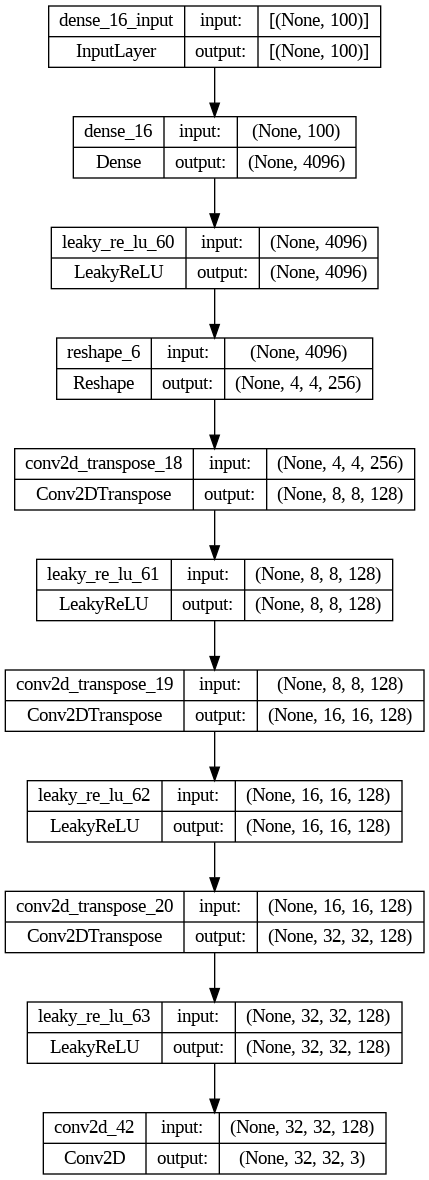

In [67]:
model= generator(100)
plot_model(model, to_file='generator.png', show_shapes=True, show_layer_names=True)

In [68]:
## generate points as input for generator
def generate_latent_points(latent_dim,n_sample):
  x_input= np.random.randn(latent_dim*n_sample)
  x_input= x_input.reshape(n_sample, latent_dim)

  return x_input

In [69]:
def generate_fake_images(g_model, latent_dim, n_sample):
  '''This function generates fake images using generator model'''
  #generate point in the latent space
  x_input = generate_latent_points(latent_dim, n_sample)
  #predict output from generator
  X = g_model.predict(x_input)
  #create a fake class label: (0)
  y = np.zeros((n_sample,1))

  return X,y

In [70]:
#defining the combined generator and discriminator model
def define_gan(g_model,d_model):
  #make weights in the discriminator not trainable
  d_model.trainable = False
  model = Sequential()
  #add generator
  model.add(g_model)
  #add discriminator
  model.add(d_model)
  #compile model
  adam = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer = adam)

  return model

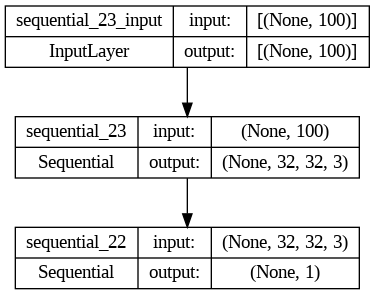

In [71]:
# size of the latent space
latent_dim = 100
#create discriminator
d_model = discriminator()
#create generator
g_model = generator(latent_dim)
#create the GAN
gan_model = define_gan(g_model, d_model)

#plot the gan model
plot_model(gan_model, to_file='gan_model.png', show_shapes=True, show_layer_names=True)

In [77]:
## training the gan model:
def train_gan(g_model,d_model, gan_model,data,latent_dim ,n_epochs=200, n_batch=128):
  batch_per_epoch= int(data.shape[0]/n_batch)
  half_batch=int(n_batch/2)
  for i in range(n_epochs):
    for j in range(batch_per_epoch):
      x_real, y_real= generate_real_samples(data,half_batch)
      #update discriminator model weights
      d_loss1,_ = d_model.train_on_batch(x_real, y_real)
      # generate fake sample
      x_fake, y_fake= generate_fake_images(g_model,latent_dim, half_batch)
      #update discriminator model weights
      d_loss2,_ = d_model.train_on_batch(x_fake, y_fake)
      #prepare points in the latent space as input for the generator
      x_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for fake samples
      y_gan = np.ones((n_batch,1))
      g_loss = gan_model.train_on_batch(x_gan, y_gan)
      #summarize loss on this batches
      print('>%d, %d/%d, d1=%.4f, d2=%.4f, g=%.4f' % (i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))

    #evaluate the model performance sometimes
    if (i+1) % 10 ==0:
      summarize_performance(i, g_model, d_model, data, latent_dim)



In [78]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_sample=150):
  #prepare real sample
  X_real, y_real = generate_real_samples(dataset, n_sample)
  #evaluate dicriminator on real examples
  _,acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  #prepare fake examples
  X_fake, y_fake = generate_fake_images(g_model,latent_dim, n_sample)
  #evaluate dicriminator on fake examples
  _,acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print(">Accuracy real: %.0f%%, fake: %.0f%%" % (acc_real*100, acc_fake*100))
  #save plot
  save_plot(X_fake, epoch)
  # save the generator model title file
  filename = 'generator_model_%03d.h5' % (epoch+1)
  g_model.save(filename)

# create and save a plot of generated images
def save_plot(examples, epochs,n=7):
  #scale the pixel value from [-1,1] to [0,1]
  examples = (examples + 1) / 2.0
  #plot the generated samples
  for i in range(n*n):
    #define subplots
    plt.subplot(n,n,1+i)
    #turn of axis
    plt.axis('off')
    #plot raw pixel data
    plt.imshow(examples[i])
  #save plot as file
  filename = 'generated_plot_%03d.png' % (epochs+1)
  plt.savefig(filename)
  plt.close()

In [74]:
latent_dim = 100
# create the discriminator
d_model = discriminator()
# create the generator
g_model = generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()

In [ ]:
train_gan(g_model,d_model, gan_model, dataset, latent_dim=100, n_epochs=100, n_batch=128)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 9ms/step
>4, 232/390, d1=4.0963, d2=6.4530, g=439.3683
2/2 [==============================] - 0s 11ms/step
>4, 233/390, d1=13.4815, d2=7.0779, g=265.3542
2/2 [==============================] - 0s 4ms/step
>4, 234/390, d1=7.9711, d2=28.1430, g=462.5901
2/2 [==============================] - 0s 6ms/step
>4, 235/390, d1=14.0319, d2=0.0000, g=510.8632
2/2 [==============================] - 0s 6ms/step
>4, 236/390, d1=64.8227, d2=57.1514, g=328.3760
2/2 [==============================] - 0s 5ms/step
>4, 237/390, d1=16.6619, d2=5.5934, g=352.9471
2/2 [==============================] - 0s 11ms/step
>4, 238/390, d1=53.0158, d2=52.4831, g=350.1361
2/2 [==============================] - 0s 6ms/step
>4, 239/390, d1=51.2758, d2=4.8909, g=275.8934
2/2 [==============================] - 0s 6ms/step
>4, 240/390, d1=54.9765, d2=32.9914, g=173.4452
2/2 [==============================] - 0s 9ms/step
>4, 241/390,

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 10ms/step
>14, 232/390, d1=0.7759, d2=0.0009, g=44.8468
2/2 [==============================] - 0s 6ms/step
>14, 233/390, d1=2.3424, d2=4.1444, g=67.4854
2/2 [==============================] - 0s 5ms/step
>14, 234/390, d1=1.7391, d2=0.0000, g=64.0844
2/2 [==============================] - 0s 6ms/step
>14, 235/390, d1=1.3461, d2=0.0000, g=39.6958
2/2 [==============================] - 0s 7ms/step
>14, 236/390, d1=1.3909, d2=5.7521, g=81.5444
2/2 [==============================] - 0s 14ms/step
>14, 237/390, d1=5.1524, d2=0.0000, g=88.9870
2/2 [==============================] - 0s 6ms/step
>14, 238/390, d1=9.1738, d2=1.4370, g=39.0967
2/2 [==============================] - 0s 9ms/step
>14, 239/390, d1=0.5726, d2=1.7902, g=49.4295
2/2 [==============================] - 0s 6ms/step
>14, 240/390, d1=1.5248, d2=0.0000, g=56.7880
2/2 [==============================] - 0s 7ms/step
>14, 241/390, d1=2.6264

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 6ms/step
>24, 232/390, d1=0.2245, d2=0.0627, g=8.1605
2/2 [==============================] - 0s 7ms/step
>24, 233/390, d1=0.4504, d2=0.5941, g=10.5543
2/2 [==============================] - 0s 8ms/step
>24, 234/390, d1=0.4607, d2=0.0189, g=9.8327
2/2 [==============================] - 0s 4ms/step
>24, 235/390, d1=0.4865, d2=0.5937, g=8.8253
2/2 [==============================] - 0s 14ms/step
>24, 236/390, d1=0.2619, d2=0.1375, g=8.6305
2/2 [==============================] - 0s 9ms/step
>24, 237/390, d1=0.5803, d2=0.3695, g=7.9032
2/2 [==============================] - 0s 7ms/step
>24, 238/390, d1=0.1627, d2=0.2284, g=8.5941
2/2 [==============================] - 0s 13ms/step
>24, 239/390, d1=0.4186, d2=0.3106, g=8.7412
2/2 [==============================] - 0s 4ms/step
>24, 240/390, d1=0.2054, d2=0.1920, g=9.1696
2/2 [==============================] - 0s 11ms/step
>24, 241/390, d1=0.5871, d2=0.

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 8ms/step
>34, 232/390, d1=4.3531, d2=0.6390, g=11.2103
2/2 [==============================] - 0s 7ms/step
>34, 233/390, d1=0.2678, d2=1.1079, g=20.5735
2/2 [==============================] - 0s 13ms/step
>34, 234/390, d1=2.8787, d2=1.3871, g=15.7271
2/2 [==============================] - 0s 11ms/step
>34, 235/390, d1=0.4920, d2=0.6109, g=21.4964
2/2 [==============================] - 0s 6ms/step
>34, 236/390, d1=2.5482, d2=1.6039, g=12.3952
2/2 [==============================] - 0s 8ms/step
>34, 237/390, d1=0.0991, d2=1.1557, g=26.9409
2/2 [==============================] - 0s 14ms/step
>34, 238/390, d1=4.5199, d2=1.0608, g=10.5933
2/2 [==============================] - 0s 7ms/step
>34, 239/390, d1=0.7238, d2=2.3871, g=27.6345
2/2 [==============================] - 0s 7ms/step
>34, 240/390, d1=3.7456, d2=0.0104, g=17.4303
2/2 [==============================] - 0s 5ms/step
>34, 241/390, d1=1.008

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 17ms/step
>44, 232/390, d1=0.7741, d2=0.6502, g=9.7169
2/2 [==============================] - 0s 5ms/step
>44, 233/390, d1=0.9122, d2=1.3648, g=12.3476
2/2 [==============================] - 0s 10ms/step
>44, 234/390, d1=1.2557, d2=0.1366, g=8.2946
2/2 [==============================] - 0s 4ms/step
>44, 235/390, d1=0.3214, d2=1.6304, g=14.4759
2/2 [==============================] - 0s 7ms/step
>44, 236/390, d1=1.3707, d2=0.2054, g=10.4155
2/2 [==============================] - 0s 7ms/step
>44, 237/390, d1=0.7233, d2=1.0551, g=11.8115
2/2 [==============================] - 0s 11ms/step
>44, 238/390, d1=1.7542, d2=2.5661, g=16.7434
2/2 [==============================] - 0s 10ms/step
>44, 239/390, d1=2.9375, d2=0.1201, g=7.9805
2/2 [==============================] - 0s 6ms/step
>44, 240/390, d1=0.6558, d2=1.7723, g=9.3057
2/2 [==============================] - 0s 4ms/step
>44, 241/390, d1=1.1183, 

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 9ms/step
>54, 232/390, d1=0.5331, d2=1.0839, g=9.4869
2/2 [==============================] - 0s 6ms/step
>54, 233/390, d1=1.1536, d2=0.3653, g=7.4330
2/2 [==============================] - 0s 8ms/step
>54, 234/390, d1=0.1689, d2=1.2722, g=13.9897
2/2 [==============================] - 0s 6ms/step
>54, 235/390, d1=1.4819, d2=0.2699, g=8.5807
2/2 [==============================] - 0s 6ms/step
>54, 236/390, d1=0.4615, d2=0.6892, g=9.0227
2/2 [==============================] - 0s 5ms/step
>54, 237/390, d1=0.8945, d2=0.6712, g=9.3433
2/2 [==============================] - 0s 7ms/step
>54, 238/390, d1=1.9216, d2=0.8270, g=6.8744
2/2 [==============================] - 0s 7ms/step
>54, 239/390, d1=0.5682, d2=1.4773, g=10.7087
2/2 [==============================] - 0s 5ms/step
>54, 240/390, d1=1.1295, d2=0.4841, g=7.9328
2/2 [==============================] - 0s 6ms/step
>54, 241/390, d1=0.8254, d2=1.53

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 7ms/step
>64, 232/390, d1=0.5970, d2=0.5107, g=3.4859
2/2 [==============================] - 0s 6ms/step
>64, 233/390, d1=0.2909, d2=0.1945, g=3.6784
2/2 [==============================] - 0s 6ms/step
>64, 234/390, d1=0.3644, d2=0.3600, g=3.7243
2/2 [==============================] - 0s 9ms/step
>64, 235/390, d1=0.2904, d2=0.4733, g=4.7849
2/2 [==============================] - 0s 6ms/step
>64, 236/390, d1=0.7654, d2=0.6950, g=4.8661
2/2 [==============================] - 0s 10ms/step
>64, 237/390, d1=0.5394, d2=0.2696, g=4.5319
2/2 [==============================] - 0s 7ms/step
>64, 238/390, d1=0.4736, d2=0.2888, g=3.8823
2/2 [==============================] - 0s 13ms/step
>64, 239/390, d1=0.7779, d2=0.6917, g=3.7497
2/2 [==============================] - 0s 9ms/step
>64, 240/390, d1=0.4144, d2=0.5332, g=4.8010
2/2 [==============================] - 0s 7ms/step
>64, 241/390, d1=0.7363, d2=0.18

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step
>74, 232/390, d1=0.4925, d2=0.6046, g=3.9088
2/2 [==============================] - 0s 13ms/step
>74, 233/390, d1=0.5067, d2=0.3964, g=4.0228
2/2 [==============================] - 0s 6ms/step
>74, 234/390, d1=0.6718, d2=0.9475, g=4.4854
2/2 [==============================] - 0s 4ms/step
>74, 235/390, d1=0.5311, d2=0.2137, g=4.1899
2/2 [==============================] - 0s 11ms/step
>74, 236/390, d1=0.6402, d2=0.9311, g=3.7998
2/2 [==============================] - 0s 4ms/step
>74, 237/390, d1=0.7667, d2=0.5810, g=3.9066
2/2 [==============================] - 0s 6ms/step
>74, 238/390, d1=0.5992, d2=0.2470, g=3.9933
2/2 [==============================] - 0s 4ms/step
>74, 239/390, d1=0.5699, d2=0.8641, g=4.7455
2/2 [==============================] - 0s 5ms/step
>74, 240/390, d1=1.0813, d2=0.6043, g=3.3344
2/2 [==============================] - 0s 6ms/step
>74, 241/390, d1=0.6452, d2=0.62

#### Prediction after training

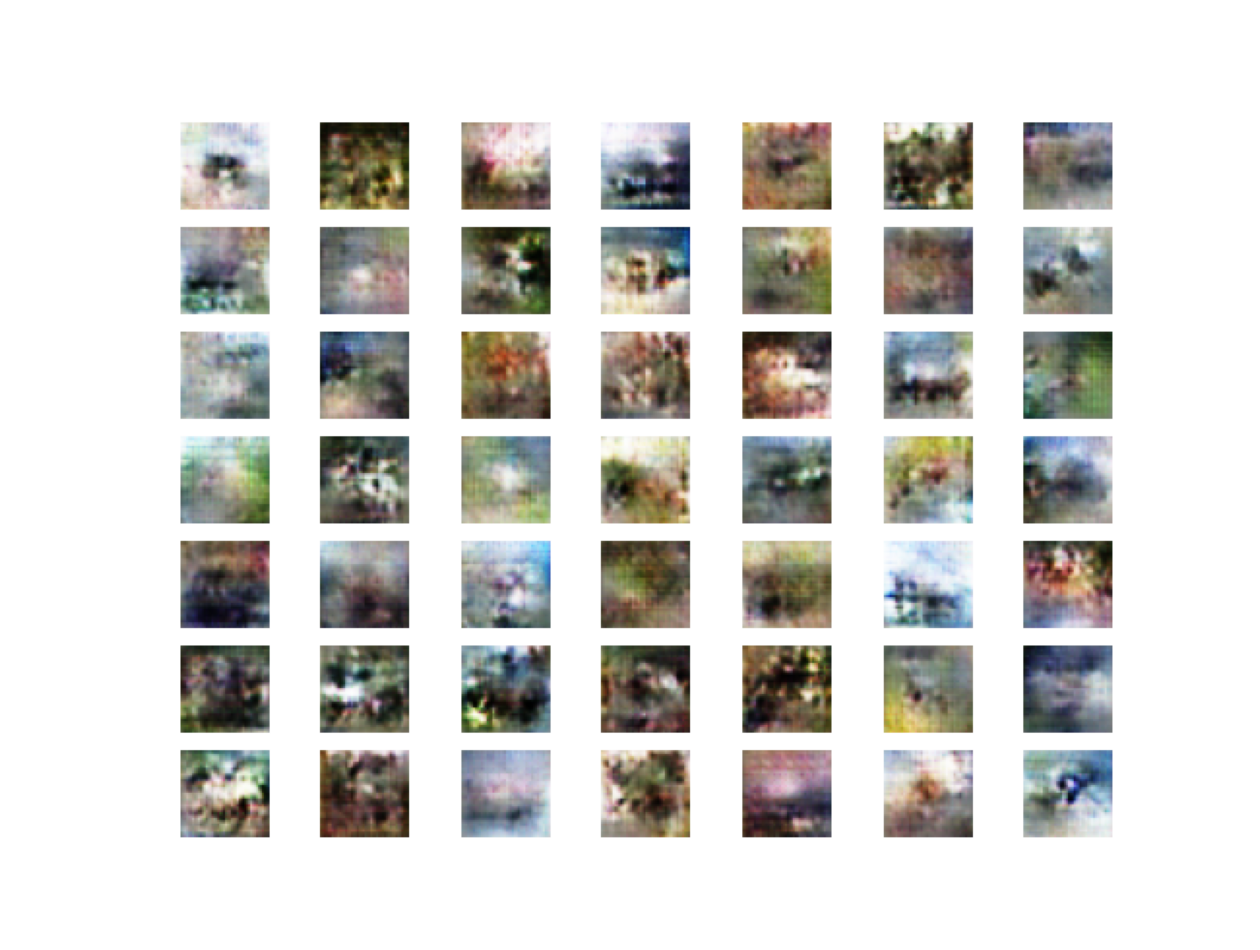

In [8]:
plt.figure(figsize=(16,16))
img= plt.imread("/content/generated_plot_070.png")
plt.axis('off')
plt.imshow(img)

In [10]:
from keras.models import load_model
from numpy.random import randn
import matplotlib.pyplot as plt

def generate_latent_points(latent_dim, n_samples):
  x_input = randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input


def create_plot(examples, n):
  for i in range(n * n):
    plt.subplot(n,n,1+i)
    plt.axis("off")
    plt.imshow(examples[i, :, :])
  plt.show()

model = load_model("/content/generator_model_070.h5")
latent_point = generate_latent_points(100,100)
X = model.predict(latent_point)



4/4 [==============================] - 0s 9ms/step
